<a href="https://colab.research.google.com/github/nokib-101/cse424/blob/main/LSTM_on_Amazon_Stock_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf

# Define the ticker symbol for Amazon (AMZN)
ticker_symbol = "AMZN"

start_date = "1997-05-15"
end_date = "2024-01-01"

# Download the historical stock price data
amazon_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Save the data to a CSV file
amazon_data.to_csv("amazon_stock_data.csv")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv('amazon_stock_data.csv')

data


,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6696,2023-12-22,153.770004,154.350006,152.710007,153.419998,153.419998,29480100
6697,2023-12-26,153.559998,153.979996,153.029999,153.410004,153.410004,25067200
6698,2023-12-27,153.559998,154.779999,153.119995,153.339996,153.339996,31434700
6699,2023-12-28,153.720001,154.080002,152.949997,153.380005,153.380005,27057000


In [ ]:
data = data[['Date','Close']]
data

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6696,2023-12-22,153.419998
6697,2023-12-26,153.410004
6698,2023-12-27,153.339996
6699,2023-12-28,153.380005


<ipython-input-85-27440ea654b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


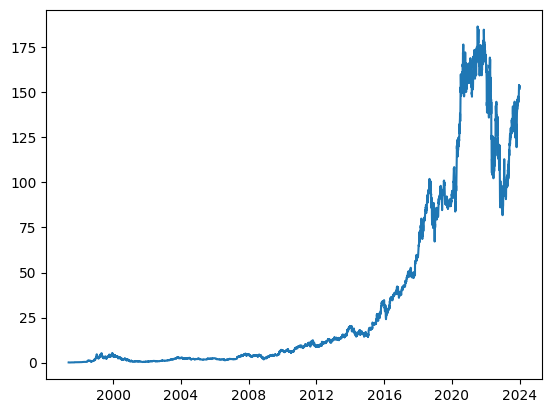

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [ ]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-12-22,153.419998,153.839996,152.119995,153.789993,154.070007,149.970001,147.419998,148.839996
2023-12-26,153.410004,153.419998,153.839996,152.119995,153.789993,154.070007,149.970001,147.419998
2023-12-27,153.339996,153.410004,153.419998,153.839996,152.119995,153.789993,154.070007,149.970001


In [ ]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[7.91670009e-02, 7.50000030e-02, 6.97920024e-02, ...,
        8.54170024e-02, 8.64579976e-02, 9.79169980e-02],
       [7.65630007e-02, 7.91670009e-02, 7.50000030e-02, ...,
        8.17710012e-02, 8.54170024e-02, 8.64579976e-02],
       [7.52599984e-02, 7.65630007e-02, 7.91670009e-02, ...,
        7.13540018e-02, 8.17710012e-02, 8.54170024e-02],
       ...,
       [1.53339996e+02, 1.53410004e+02, 1.53419998e+02, ...,
        1.53789993e+02, 1.54070007e+02, 1.49970001e+02],
       [1.53380005e+02, 1.53339996e+02, 1.53410004e+02, ...,
        1.52119995e+02, 1.53789993e+02, 1.54070007e+02],
       [1.51940002e+02, 1.53380005e+02, 1.53339996e+02, ...,
        1.53839996e+02, 1.52119995e+02, 1.53789993e+02]])

In [ ]:
shifted_df_as_np.shape

(6694, 8)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.64364011,  0.64439086,  0.64450003, ...,  0.64846779,
         0.65147061,  0.60750288],
       [ 0.64406916,  0.64364011,  0.64439285, ...,  0.63055903,
         0.64846779,  0.65147061],
       [ 0.62862675,  0.64406916,  0.6436421 , ...,  0.64900401,
         0.63055903,  0.64846779]])

In [ ]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((6694, 7), (6694,))

In [ ]:
X = dc(np.flip(X, axis=1))
X

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.60750288,  0.65147061,  0.64846779, ...,  0.64900401,
         0.64450003,  0.64439086],
       [ 0.65147061,  0.64846779,  0.63055903, ...,  0.64450003,
         0.64439285,  0.64364011],
       [ 0.64846779,  0.63055903,  0.64900401, ...,  0.64439285,
         0.6436421 ,  0.64406916]])

In [ ]:
split_index = int(len(X) * 0.90)

split_index

6024

In [ ]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6024, 7), (670, 7), (6024,), (670,))

In [ ]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6024, 7, 1), (670, 7, 1), (6024, 1), (670, 1))

In [ ]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape


(torch.Size([6024, 7, 1]),
 torch.Size([670, 7, 1]),
 torch.Size([6024, 1]),
 torch.Size([670, 1]))

In [ ]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [ ]:
train_dataset

In [ ]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [ ]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('------------------------------------------------')
    print()

In [ ]:
learning_rate = 0.1
num_epochs = 15
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.017
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.003
------------------------------------------------

Epoch: 2
Batch 100, Loss: 0.000
Batch 200, Loss: 0.001
Batch 300, Loss: 0.000

Val Loss: 0.002
------------------------------------------------

Epoch: 3
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.002
------------------------------------------------

Epoch: 4
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.001

Val Loss: 0.002
------------------------------------------------

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.002
------------------------------------------------

Epoch: 6
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.001

Val Loss: 0.005
------------------------------------------------

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.001
Batch 300, Loss: 0.000

Val Loss: 0.003
-----------------------------------

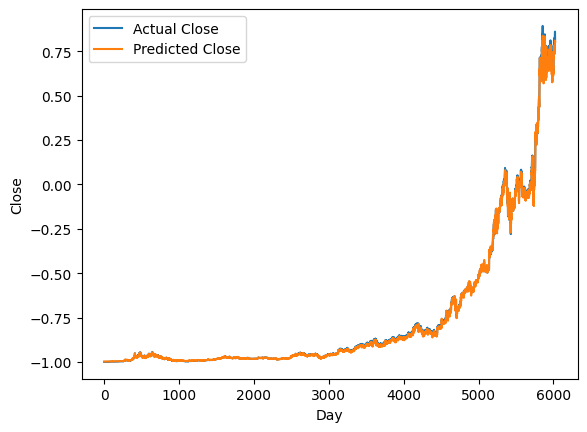

In [ ]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  0.27402686,   0.27698378,   0.27262621, ..., 168.31869772,
       168.86798479, 168.35321366])

In [ ]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([7.91646240e-02, 7.65634224e-02, 7.52572635e-02, ...,
       1.73565505e+02, 1.73371004e+02, 1.69324496e+02])

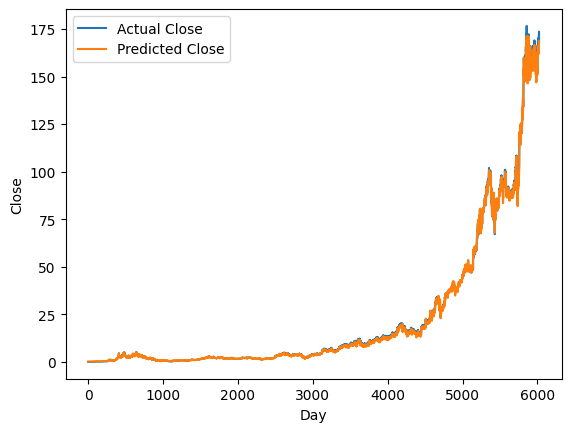

In [ ]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [ ]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([164.47922412, 161.29855484, 159.84506119, 161.7237846 ,
       161.36062796, 156.67182313, 157.8940266 , 155.45777898,
       155.4950851 , 158.95635066, 161.5119423 , 158.9750593 ,
       158.55275311, 159.81792644, 157.63028254, 159.37517747,
       160.49085951, 160.46882711, 158.59966367, 158.22999291,
       158.3209238 , 159.08975673, 156.85588037, 157.56878747,
       157.61959983, 160.79516675, 161.68342151, 164.606205  ,
       164.17487241, 165.47042644, 165.38562059, 166.63730991,
       170.34333298, 169.54137363, 167.33719988, 169.9937048 ,
       170.05242082, 167.01476205, 164.97934403, 167.26282664,
       167.74927913, 166.99660922, 166.66164337, 170.63690748,
       179.53663528, 178.19618274, 178.62084557, 177.94145396,
       177.71805076, 175.67558504, 175.94950046, 173.92666604,
       171.56057305, 170.81659604, 172.11383973, 172.71884143,
       175.01639165, 175.72497452, 177.48008528, 173.69165748,
       173.89547385, 172.9773942 , 162.50826921, 161.92

In [ ]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([165.59350551, 163.52699535, 165.31849514, 164.58050423,
       159.52450756, 161.19549612, 157.5970005 , 158.07350395,
       161.14500613, 163.519503  , 161.61400056, 161.58999502,
       162.38400069, 160.15400946, 162.24949412, 162.95249664,
       163.25799331, 161.50549488, 161.1535045 , 160.93249685,
       161.69949561, 159.35049384, 160.31100421, 159.90049791,
       163.20550796, 164.05749597, 167.48250034, 167.34150743,
       169.19349627, 169.15649584, 170.76249883, 174.46200778,
       174.34500373, 172.69799847, 175.27200417, 175.19099452,
       172.45399686, 170.07299699, 172.19450477, 172.40699738,
       172.00799639, 171.64849699, 175.54899323, 183.78700425,
       184.82899669, 186.57049561, 185.9669946 , 185.92750414,
       183.86799722, 184.08399699, 181.55999773, 178.68150137,
       177.47950723, 178.65950232, 179.25999638, 181.90150548,
       182.83200198, 184.99099931, 181.3195033 , 181.51600518,
       179.99600303, 166.37950193, 166.57400289, 168.31

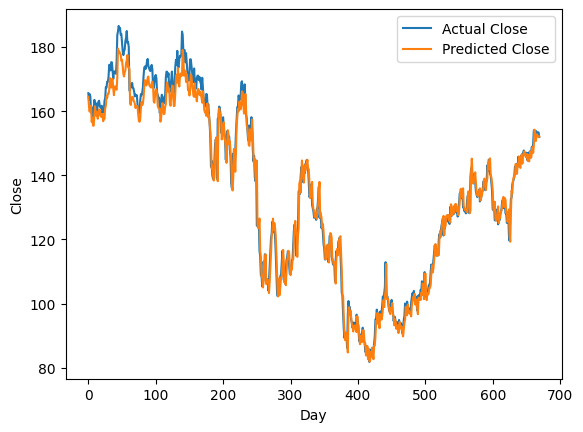

In [ ]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [ ]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6696,2023-12-22,153.770004,154.350006,152.710007,153.419998,153.419998,29480100
6697,2023-12-26,153.559998,153.979996,153.029999,153.410004,153.410004,25067200
6698,2023-12-27,153.559998,154.779999,153.119995,153.339996,153.339996,31434700
6699,2023-12-28,153.720001,154.080002,152.949997,153.380005,153.380005,27057000
